In [0]:
#!pip install tensorflow==2.1

In [0]:
import keras.backend as K
import numpy as np
import tensorflow as tf

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

Using TensorFlow backend.


TensorFlow version: 2.1.0
Eager execution: True


In [0]:
@tf.custom_gradient
def O2RU(x):
    r=2
    g =  r*(r**2 * K.abs(x) + 1)**((1-r)/r)
    def grad(dy):
      return dy * g #dy = 1 
    return K.sign(x)*((r**2 * K.abs(x) + 1)**(1/r) - 1), grad

@tf.custom_gradient
def O3RU(x):
    r=3
    g =  r*(r**2 * K.abs(x) + 1)**((1-r)/r)
    def grad(dy):
      return dy * g #dy = 1 
    return K.sign(x)*((r**2 * K.abs(x) + 1)**(1/r) - 1), grad


# if you want to check diff in 0, automatic diff by TF gives 0 but it should be r
with tf.GradientTape() as g:
  x = tf.constant([0.0])
  g.watch(x)
  y = O3RU(x)
dy_dx = g.gradient(y, x)
print(dy_dx)

@tf.custom_gradient
def E1RU(x):
  r = 1
  gradient = tf.where(x >= 0, r*(r**2 * x + 1)**((1-r)/r), r*K.exp(r*x))
  def grad(dy):
      return dy * gradient
  return tf.where(x >= 0, (r**2 * x + 1)**(1/r) - 1/r, K.exp(r*x) - 1/r), grad

@tf.custom_gradient
def E2RU(x):
  r = 2
  gradient = tf.where(x >= 0, r*(r**2 * x + 1)**((1-r)/r), r*K.exp(r*x))
  def grad(dy):
      return dy * gradient
  return tf.where(x >= 0, (r**2 * x + 1)**(1/r) - 1/r, K.exp(r*x) - 1/r), grad

@tf.custom_gradient
def E3RU(x):
  r = 3
  gradient = tf.where(x >= 0, r*(r**2 * x + 1)**((1-r)/r), r*K.exp(r*x))
  def grad(dy):
      return dy * gradient
  return tf.where(x >= 0, (r**2 * x + 1)**(1/r) - 1/r, K.exp(r*x) - 1/r), grad

with tf.GradientTape() as g:
  x = tf.constant([-5.0,0.0,5.0,10.0,100.0])
  g.watch(x)
  y = E2RU(x)
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor([3.], shape=(1,), dtype=float32)
tf.Tensor([9.0799862e-05 2.0000000e+00 4.3643579e-01 3.1234753e-01 9.9875227e-02], shape=(5,), dtype=float32)


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = (x_train/255.0).reshape(x_train.shape[0], 32,32,3).astype(np.float32)
x_test = (x_test/255.0).reshape(x_test.shape[0], 32,32,3).astype(np.float32)
print(x_train.shape)
print(x_test.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
features, labels = next(iter(train_dataset))

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)
  return loss_object(y_true=y, y_pred=y_)

In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
tf.compat.v1.random.set_random_seed(0)
shape = (32,32,3)
model_bru = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(filters=96,kernel_size=(3,3), strides=1, padding='same', activation=E3RU, input_shape=shape),
                                 tf.keras.layers.Conv2D(filters=96,kernel_size=(2,2), strides=1, padding='valid', activation=O3RU),
                                 tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
                                 tf.keras.layers.Lambda(E1RU),
                                 tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation=E2RU),
                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation=O2RU),
                                 tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
                                 tf.keras.layers.Lambda(E1RU),
                                 tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation=E2RU),
                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(1,1), strides=1, padding='same', activation=O2RU),
                                 tf.keras.layers.Conv2D(filters=10,kernel_size=(1,1), strides=1, padding='same', activation=E1RU),
                                 tf.keras.layers.AveragePooling2D(pool_size=(6,6), strides=1, padding='same'),
                                 tf.keras.layers.Lambda(E1RU),
                                 #tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(10, activation='softmax')
])

model_elu = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(filters=96,kernel_size=(3,3), strides=1, padding='same', activation='elu', input_shape=shape),
                                 tf.keras.layers.Conv2D(filters=96,kernel_size=(2,2), strides=1, padding='valid', activation='elu'),
                                 tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
                                 tf.keras.layers.Lambda(tf.nn.elu),
                                 tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation='elu'),
                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation='elu'),
                                 tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
                                 tf.keras.layers.Lambda(tf.nn.elu),
                                 tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation='elu'),
                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(1,1), strides=1, padding='same', activation='elu'),
                                 tf.keras.layers.Conv2D(filters=10,kernel_size=(1,1), strides=1, padding='same', activation='elu'),
                                 tf.keras.layers.AveragePooling2D(pool_size=(6,6), strides=1, padding='same'),
                                 tf.keras.layers.Lambda(tf.nn.elu),
                                 #tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(10, activation='softmax')
])

model_relu = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(filters=96,kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=shape),
                                 tf.keras.layers.Conv2D(filters=96,kernel_size=(2,2), strides=1, padding='valid', activation='relu'),
                                 tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
                                 tf.keras.layers.Lambda(tf.nn.relu),
                                 tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation='relu'),
                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation='relu'),
                                 tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
                                 tf.keras.layers.Lambda(tf.nn.relu),
                                 tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation='relu'),
                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(1,1), strides=1, padding='same', activation='relu'),
                                 tf.keras.layers.Conv2D(filters=10,kernel_size=(1,1), strides=1, padding='same', activation='relu'),
                                 tf.keras.layers.AveragePooling2D(pool_size=(6,6), strides=1, padding='same'),
                                 tf.keras.layers.Lambda(tf.nn.relu),
                                 #tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(10, activation='softmax')
])

model_leaky_relu = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(filters=96,kernel_size=(3,3), strides=1, padding='same', activation=tf.nn.leaky_relu, input_shape=shape),
                                 tf.keras.layers.Conv2D(filters=96,kernel_size=(2,2), strides=1, padding='valid', activation=tf.nn.leaky_relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
                                 tf.keras.layers.Lambda(tf.nn.leaky_relu),
                                 tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation=tf.nn.leaky_relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
                                 tf.keras.layers.Lambda(tf.nn.leaky_relu),
                                 tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3), strides=1, padding='same', activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Conv2D(filters=192,kernel_size=(1,1), strides=1, padding='same', activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Conv2D(filters=10,kernel_size=(1,1), strides=1, padding='same', activation=tf.nn.leaky_relu),
                                 tf.keras.layers.AveragePooling2D(pool_size=(6,6), strides=1, padding='same'),
                                 tf.keras.layers.Lambda(tf.nn.leaky_relu),
                                 #tf.keras.layers.Dropout(0.5),

                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(10, activation='softmax')
])

In [0]:
optimizer = tf.keras.optimizers.SGD(0.01)

loss_value, grads = grad(model_bru, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),loss_value.numpy()))

Step: 0, Initial Loss: 2.311265468597412


In [0]:
import time

def train(model, data, num_epochs):
  train_loss_results = []
  train_accuracy_results = []

  epoch = 0
  for epoch in range(num_epochs):
    start = time.time()
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 64
    for x, y in data:
      # Optimize the model
      loss_value, grads = grad(model, x, y)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Track progress
      epoch_loss_avg(loss_value)  # Add current batch loss
      # Compare predicted label to actual label
      # training=True is needed only if there are layers with different
      # behavior during training versus inference (e.g. Dropout).
      epoch_accuracy(y, model(x, training=True))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    #if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    print ('Time taken for epoch {} sec\n'.format(time.time() - start))
    epoch +=1
  return train_loss_results, train_accuracy_results

In [0]:
train_epoch = 40
l_bru, a_bru = train(model_bru, train_dataset, train_epoch)

Epoch 000: Loss: 2.285, Accuracy: 15.166%
Time taken for epoch 95.35191535949707 sec

Epoch 001: Loss: 2.222, Accuracy: 24.060%
Time taken for epoch 94.27204728126526 sec

Epoch 002: Loss: 2.171, Accuracy: 30.656%
Time taken for epoch 94.79860854148865 sec

Epoch 003: Loss: 2.137, Accuracy: 34.418%
Time taken for epoch 96.02852249145508 sec

Epoch 004: Loss: 2.117, Accuracy: 36.350%
Time taken for epoch 96.7067084312439 sec

Epoch 005: Loss: 2.101, Accuracy: 37.842%
Time taken for epoch 96.48412775993347 sec

Epoch 006: Loss: 2.087, Accuracy: 39.434%
Time taken for epoch 96.40634346008301 sec

Epoch 007: Loss: 2.073, Accuracy: 41.210%
Time taken for epoch 95.87389206886292 sec

Epoch 008: Loss: 2.060, Accuracy: 42.676%
Time taken for epoch 93.62319302558899 sec

Epoch 009: Loss: 2.046, Accuracy: 44.240%
Time taken for epoch 93.16230845451355 sec

Epoch 010: Loss: 2.029, Accuracy: 45.914%
Time taken for epoch 93.45180487632751 sec

Epoch 011: Loss: 2.013, Accuracy: 47.712%
Time taken fo

In [0]:
l_elu, a_elu = train(model_elu, train_dataset, train_epoch)

Epoch 000: Loss: 2.301, Accuracy: 11.386%
Time taken for epoch 49.41272950172424 sec

Epoch 001: Loss: 2.299, Accuracy: 10.128%
Time taken for epoch 49.771669149398804 sec

Epoch 002: Loss: 2.289, Accuracy: 11.780%
Time taken for epoch 49.778857707977295 sec

Epoch 003: Loss: 2.253, Accuracy: 20.256%
Time taken for epoch 49.783724308013916 sec

Epoch 004: Loss: 2.225, Accuracy: 23.422%
Time taken for epoch 50.006428718566895 sec

Epoch 005: Loss: 2.214, Accuracy: 24.578%
Time taken for epoch 49.94866704940796 sec

Epoch 006: Loss: 2.205, Accuracy: 25.604%
Time taken for epoch 49.7705864906311 sec

Epoch 007: Loss: 2.193, Accuracy: 27.310%
Time taken for epoch 49.80912804603577 sec

Epoch 008: Loss: 2.179, Accuracy: 28.868%
Time taken for epoch 50.231884479522705 sec

Epoch 009: Loss: 2.167, Accuracy: 30.112%
Time taken for epoch 50.03085422515869 sec

Epoch 010: Loss: 2.161, Accuracy: 30.842%
Time taken for epoch 49.985615253448486 sec

Epoch 011: Loss: 2.156, Accuracy: 31.314%
Time ta

In [0]:
l_relu, a_relu = train(model_relu, train_dataset, train_epoch)

Epoch 000: Loss: 2.302, Accuracy: 10.022%
Time taken for epoch 48.11630296707153 sec

Epoch 001: Loss: 2.302, Accuracy: 10.000%
Time taken for epoch 48.266438245773315 sec

Epoch 002: Loss: 2.302, Accuracy: 10.000%
Time taken for epoch 48.39504098892212 sec

Epoch 003: Loss: 2.302, Accuracy: 10.000%
Time taken for epoch 48.30947685241699 sec

Epoch 004: Loss: 2.302, Accuracy: 10.000%
Time taken for epoch 48.37385153770447 sec

Epoch 005: Loss: 2.301, Accuracy: 10.000%
Time taken for epoch 48.399008989334106 sec

Epoch 006: Loss: 2.300, Accuracy: 10.000%
Time taken for epoch 48.42073702812195 sec

Epoch 007: Loss: 2.298, Accuracy: 10.000%
Time taken for epoch 48.43233895301819 sec

Epoch 008: Loss: 2.296, Accuracy: 10.006%
Time taken for epoch 48.50907349586487 sec

Epoch 009: Loss: 2.290, Accuracy: 10.222%
Time taken for epoch 48.313626766204834 sec

Epoch 010: Loss: 2.282, Accuracy: 12.596%
Time taken for epoch 48.414029598236084 sec

Epoch 011: Loss: 2.275, Accuracy: 14.714%
Time tak

In [0]:
l_leaky_relu, a_leaky_relu = train(model_leaky_relu, train_dataset, train_epoch)

Epoch 000: Loss: 2.303, Accuracy: 10.366%
Time taken for epoch 49.84649324417114 sec

Epoch 001: Loss: 2.303, Accuracy: 9.974%
Time taken for epoch 49.823970556259155 sec

Epoch 002: Loss: 2.302, Accuracy: 10.002%
Time taken for epoch 49.51475930213928 sec

Epoch 003: Loss: 2.302, Accuracy: 9.998%
Time taken for epoch 49.66905951499939 sec

Epoch 004: Loss: 2.302, Accuracy: 10.000%
Time taken for epoch 49.742247343063354 sec

Epoch 005: Loss: 2.302, Accuracy: 10.002%
Time taken for epoch 49.98442840576172 sec

Epoch 006: Loss: 2.302, Accuracy: 9.998%
Time taken for epoch 49.894030809402466 sec

Epoch 007: Loss: 2.302, Accuracy: 10.000%
Time taken for epoch 49.94715094566345 sec

Epoch 008: Loss: 2.302, Accuracy: 9.994%
Time taken for epoch 49.77031207084656 sec

Epoch 009: Loss: 2.302, Accuracy: 9.974%
Time taken for epoch 49.73806643486023 sec

Epoch 010: Loss: 2.301, Accuracy: 9.888%
Time taken for epoch 49.675946950912476 sec

Epoch 011: Loss: 2.301, Accuracy: 10.358%
Time taken for

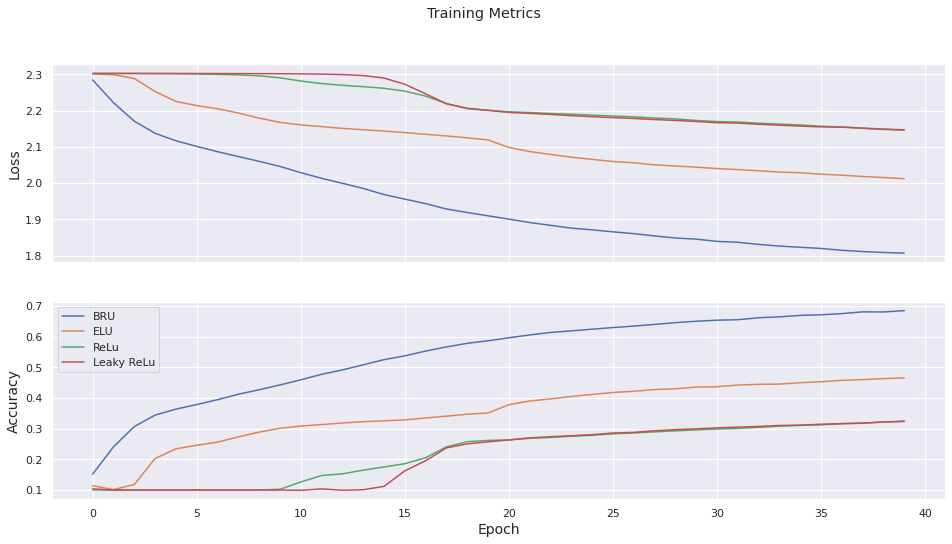

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, axes = plt.subplots(2, sharex=True, figsize=(16, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(l_bru, label='BRU')
axes[0].plot(l_elu, label='ELU')
axes[0].plot(l_relu, label='ReLu')
axes[0].plot(l_leaky_relu, label='Leaky ReLu')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(a_bru, label='BRU')
axes[1].plot(a_elu, label='ELU')
axes[1].plot(a_relu, label='ReLu')
axes[1].plot(a_leaky_relu, label='Leaky ReLu')

plt.legend()
plt.show()

In [0]:
def eval(model, data):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  for x, y in data:
    loss_value, _ = grad(model, x, y)
    epoch_loss_avg(loss_value)
    epoch_accuracy(y, model(x, training=False))
  
  return epoch_loss_avg.result(), epoch_accuracy.result()

In [0]:
l, a = eval(model_bru, test_dataset)
print("Loss: {:.3f}, Accuracy: {:.3%}".format(l,a))

Loss: 1.816, Accuracy: 64.080%


In [0]:
l, a = eval(model_elu, test_dataset)
print("Loss: {:.3f}, Accuracy: {:.3%}".format(l,a))

Loss: 2.010, Accuracy: 39.490%


In [0]:
l, a = eval(model_relu, test_dataset)
print("Loss: {:.3f}, Accuracy: {:.3%}".format(l,a))

Loss: 2.141, Accuracy: 31.260%


In [0]:
l, a = eval(model_leaky_relu, test_dataset)
print("Loss: {:.3f}, Accuracy: {:.3%}".format(l,a))

Loss: 2.147, Accuracy: 29.590%
